### Answer 3 Feed Forward Neural Network Implementation

For this exercise, you can use PyTorch using which building and training neural networks are more convenient. You can also use Python to fully implement the neural network (it would be much harder). Implement a Feed Forward Neural Net-work with n layers using either PyTorch, that takes as input the number of layers n and the number of nodes in each layer,Sfor∈ {1,...,n}. The network must receive a dataset{xi,yi}Ni=1,and must output all the learned weights and biasses of all layers as well as the activations of the last layer. The code must allow specifying the following activation functions: sigmoid, hyperbolic tangent, rectifier linear and identity activation. The loss function must be the cross-entropy loss.

In [369]:
from __future__ import print_function, division
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
import os
from skimage import io, transform
import numpy as np
from torchvision import transforms, utils
import torch
import torch.nn as nn
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

#### Building the Feed Forward Model Class

In [424]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, n_layers, nodes, activation_list):
        '''
        input_size   : number of input features ,integer
        n_layers     : number of layers
        nodes        : list of number of nodes in each layer,list
        activation_list: list of activation functions for each list 
        '''
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.n_layers  = n_layers
        self.nodes = nodes
        self.activation_list = activation_list
        
        self.activation_map = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'identity': nn.Identity(),
                          'sigmoid': nn.Sigmoid()}
        
        #Defining the first layer
        self.hidden_layer = OrderedDict()
        self.hidden_layer['hidden_0a'] = nn.Linear(self.input_size, self.nodes[0])
        self.hidden_layer['hidden_0b']= self.activation_map[self.activation_list[0]]
        
        # Appending all the hidden layers to the list of first layer
        for idx in range(1, n_layers):
            self.hidden_layer['hidden_%sa'%idx] = nn.Linear(self.nodes[idx-1], self.nodes[idx])
            self.hidden_layer['hidden_%sb'%idx] = self.activation_map[self.activation_list[idx]]
        
        self.hidden_layer = nn.Sequential(self.hidden_layer)
        
        self.output_layer = nn.Linear(self.nodes[-1], 2)
        self.output_activation = self.activation_map[self.activation_list[-1]]
        
        
    def forward(self, x):
        
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        
        return x

### Training 

In [450]:


def do_train_epoch(model, x, y, criterion, optimizer):
    '''
    model        : model generated from FeedForward()
    x            : features
    y            : dependent variable
    criterion    : the loss function to be used (cross entropy)
    optimizer    : optimizer such as adam
    '''
    model.train()
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    optimizer.zero_grad()
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error
    
    
def do_eval_epoch(model, x, y, criterion):
    model.eval()
    
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error


def run_model(model, X_train, y_train, X_test, y_test):
    np.random.seed(0)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    losses, accs, errors = [], [], []
    epoch_no = 4000
    for epoch in range(epoch_no):
        tr_loss, tr_acc, tr_error = do_train_epoch(model, X_train, y_train, criterion, optimizer)
        te_loss, te_acc, te_error = do_eval_epoch(model, X_test, y_test, criterion)

        losses.append([tr_loss, te_loss])
        accs.append([tr_acc, te_acc])
        errors.append([tr_error, te_error])
        
    return losses, accs, errors
#Defining function to train and test the model


def classification_error(pred, y):
    correct = 0.0
    with torch.no_grad():
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        
    accuracy = correct/y.size(0)
    error = y.size(0) - correct
    
    return accuracy, error
    

### Answer 4

### 4.1
Download the dataset of HW04. Plot the two-dimensional data in the training set. Use the
training labels (-1 and +1) to plot data in different classes with different colors and markers.
Are the data linearly separable?

In [451]:
# importing data
mat = scipy.io.loadmat('hw04_data.mat') 
X_train = np.array(mat['X_trn'])
y_train = np.array(mat['y_trn'])
X_test = np.array(mat['X_tst'])
y_test = np.array(mat['y_tst'])

In [452]:
# exploring data
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1000, 2) (1000, 1) (1000, 2) (1000, 1)


In [453]:
X_train

array([[-3.70136348, -0.62904582],
       [ 0.96603447, -1.73058471],
       [ 3.93741446,  0.28055726],
       ...,
       [-0.10402457,  1.01845246],
       [-0.18018865,  0.87064787],
       [-1.49387717,  0.45812531]])

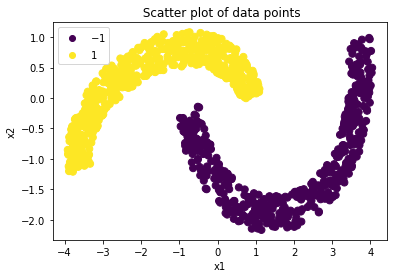

In [454]:
# plotting the data
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=50);
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(" Scatter plot of data points") 
plt.legend(*scatter.legend_elements()) 
plt.show()

### We see that the data is not linearly separable

### Answer 4.2
Run the NN code (with one hidden layer and with two hidden layers) on the training dataset
and evaluate on the test dataset.    
Here, you need to explore the effect of different number of
neurons in the hidden layer(s).     
Report classification error on the training set and on the test
set, when using 10, 30 and 50 neurons in the hidden layer(s).    
Plot the data (use different
colors for data in different classes) and plot the classification results (points predicted to be
in class +1 with circles and points predicted to be in class −1 with squares)

In [455]:
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))
print(X_train.shape, y_train.shape)

X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

# Converting the labels with value -1 to 0 to make it work for cross entropy loss
mask = y_train[:,0]== -1
y_train[mask, 0] = 0 

mask = y_test[:,0]== -1
y_test[mask, 0] = 0 

torch.Size([1000, 2]) torch.Size([1000, 1])


In [646]:
def plot_data(X_train, y_train, X_test, y_test, title=''):
    pred = model(X_train)
    #correct = 0
    _, predicted = torch.max(pred, 1)
    
    
    #y = y_train.reshape(-1).long()
    #correct += (predicted == y).sum().item()
    predicted = predicted.numpy()
    
    test_pred = model(X_test)
    _, predicted_test = torch.max(test_pred, 1)
    predicted_test
    #print(predicted)
    x_p0,x_p1 = X_train[np.where(predicted == 0)[0]], X_train[np.where(predicted == 1)[0]]
    x_t0, x_t1 = X_train[np.where(y_train == 0)[0]], X_train[np.where(y_train == 1)[0]]
    #x_ts0, x_ts1 = X_test[np.where(y_test == 0)[0]], X_test[np.where(y_test == 1)[0]]
    plt.scatter(x_t0[:,0], x_t0[:,1], color='red', label='train -1')
    plt.scatter(x_t1[:,0], x_t1[:,1], color='yellow', label='train +1')
    plt.scatter(x_p0[:,0], x_p0[:,1], color='black', marker='+', label='pred-1')
    plt.scatter(x_p1[:,0], x_p1[:,1], color='blue', marker='o', label='pred+1')
    plt.title(title)
    plt.legend()
    plt.xlabel('x1')
    plt.ylabel('x2')


In [456]:
# Defining parameters and creating an object of the model
                                  
n_layers = 1
nodes = [10]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {errors[-1]}")
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Train and test classification error respectively: [3.0, 2.0]
Weights of the output layer : Parameter containing:
tensor([[ 0.1888,  0.9260,  0.8274, -1.0088, -0.0258, -1.5635,  1.3846, -1.6249,
          1.4933,  0.7165],
        [-0.1831, -1.1977, -0.5766,  0.8343, -0.2825,  1.4781, -1.3291,  1.7634,
         -1.2233, -0.8911]], requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([-0.1822,  0.3786], requires_grad=True)


In [462]:
X_test.shape

torch.Size([1000, 2])

### Reporting classification error for Train and test for 1 hidden layer and 10,30 and 50 neurons



In [647]:
                                 
n_layers = 1
nodes = [10]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]

print("Train classification error for 1 hidden layer and 10 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 1 hidden layer and 10 nodes:",test_error/y_test.shape[0])

Train classification error for 1 hidden layer and 10 nodes: 0.005
Test  classification error for 1 hidden layer and 10 nodes: 0.007


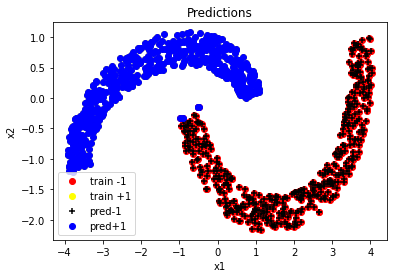

In [648]:
plot_data(X_train, y_train, X_test, y_test, title='Predictions')

In [629]:
                                  
n_layers = 1
nodes = [30]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]
print("Train classification error for 1 hidden layer and 30 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 1 hidden layer and 30 nodes:",test_error/y_test.shape[0])

Train classification error for 1 hidden layer and 30 nodes: 0.003
Test  classification error for 1 hidden layer and 30 nodes: 0.002


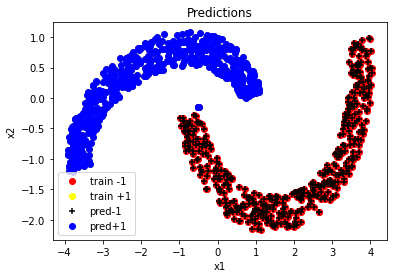

In [630]:
plot_data(X_train, y_train, X_test, y_test, title='Predictions')

In [631]:
n_layers = 1
nodes = [50]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]

print("Train classification error for 1 hidden layer and 50 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 1 hidden layer and 50 nodes:",test_error/y_test.shape[0])

Train classification error for 1 hidden layer and 50 nodes: 0.003
Test  classification error for 1 hidden layer and 50 nodes: 0.001


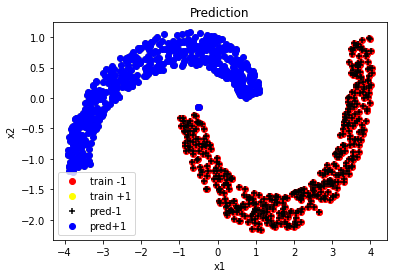

In [632]:
plot_data(X_train, y_train, X_test, y_test, title='Prediction')

### We see that classification error reduced  for both train and test data sets

### Reporting classification error for Train and test for 2 hidden layer and 10,30 and 50 neurons

In [640]:
n_layers = 2
nodes = [10, 10]
activation_list = ['relu', 'relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]

print("Train classification error for 2 hidden layers and 10 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 2 hidden layers and 10 nodes:",test_error/y_test.shape[0])

Train classification error for 2 hidden layers and 10 nodes: 0.0
Test  classification error for 2 hidden layers and 10 nodes: 0.0


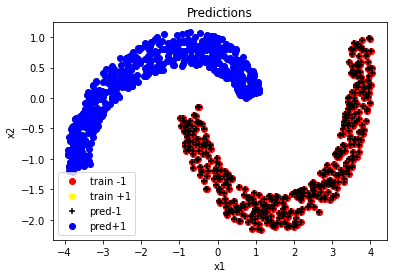

In [641]:
plot_data(X_train, y_train, X_test, y_test, title='Predictions')

In [642]:
n_layers = 2
nodes = [30, 30]
activation_list = ['relu', 'relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]

print("Train classification error for 2 hidden layers and 30 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 2 hidden layers and 30 nodes:",test_error/y_test.shape[0])

Train classification error for 2 hidden layers and 30 nodes: 0.0
Test  classification error for 2 hidden layers and 30 nodes: 0.0


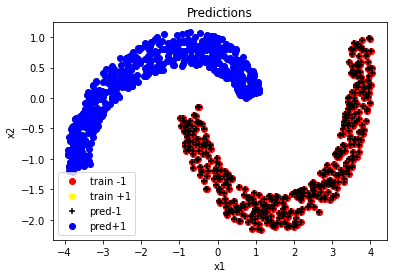

In [643]:
plot_data(X_train, y_train, X_test, y_test, title='Predictions')

In [644]:
n_layers = 2
nodes = [50, 50]
activation_list = ['relu', 'relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
train_error = errors[-1][0]
test_error = errors[-1][1]

print("Train classification error for 2 hidden layers and 50 nodes:",train_error/y_train.shape[0])
print("Test  classification error for 2 hidden layers and 50 nodes:",test_error/y_test.shape[0])

Train classification error for 2 hidden layers and 50 nodes: 0.0
Test  classification error for 2 hidden layers and 50 nodes: 0.0


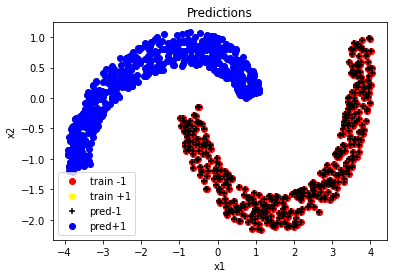

In [645]:
plot_data(X_train, y_train, X_test, y_test, title='Predictions')

### We observe that with 2 hidden layers classification error is zero for all cases